__File: asymptotic_check.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Jun 16, 2021__

Testing $^4$He momentum distributions by checking asymptotic relation between single-nucleon and pair momentum distributions: $n_p(q)=2n_{pp}(q)+n_{pn}(q)$ in high-$q$ limit where $Q$ has been integrated out.

__Revision history:<br/>__
* Jul 01, 2021 - Including $^8$He now. Updated with changes to snmd.py and pmd.py.
* Jul 07, 2021 - Added $^9$Be.
* Jul 08, 2021 - Looking at $Q$ dependence in pair momentum distributions by adding $^{12}$C at $Q=0$ fm$^{-1}$ and $^{4}$He at several fixed $Q$.
* Jul 12, 2021 - Trying SLy4 density for $^4$He.

In [1]:
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
import time
# Scripts made by A.T.
from figures import figures_functions as ff
from densities import load_density
from dmd import deuteron_momentum_distributions
from misc.fourier_transform import hankel_transformation_k2r
from misc.integration import gaussian_quadrature_mesh
import observables as ob
from pmd import pair_momentum_distributions
from potentials.vsrg_macos import vnn
from snmd import single_nucleon_momentum_distributions
from srg.srg_unitary_transformation import SRG_unitary_transformation

Which versions of QMC data are you using? AV18, AV18+UX, etc.?

Nucleus: Single-nucleon distribution, Pair distribution, Single-nucleon densities

$^4$He: AV18+UX, AV18+UX, SLy4<br/>
$^8$He: AV18+UX, AV18+UX, AV18+UX<br/>
$^9$Be: AV18+UX, AV18+UX, AV18+UX<br/>
$^{12}$C: AV18+UX, AV18+UX, SLy4<br/>
$^{16}$O: AV18, n/a, SLy4<br/>
$^{40}$Ca: AV18, n/a, SLy4

__Set-up__

In [2]:
def setup_rc_params(presentation=False):
    """
    Set matplotlib's rc parameters for the plots
    
    Parameters
    ----------
    presentation : bool, optional
        Option to enlarge font sizes for presentations.
    
    """

    if presentation:
        fontsize = 14
    else:
        fontsize = 9
    black = 'k'

    mpl.rcdefaults()  # Set to defaults

    mpl.rc('text', usetex=True)
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'serif'

#     mpl.rcParams['axes.labelsize'] = fontsize
    mpl.rcParams['axes.edgecolor'] = black
    # mpl.rcParams['axes.xmargin'] = 0
    mpl.rcParams['axes.labelcolor'] = black
#     mpl.rcParams['axes.titlesize'] = fontsize

    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.labelsize'] = fontsize
    mpl.rcParams['ytick.labelsize'] = fontsize
    mpl.rcParams['xtick.color'] = black
    mpl.rcParams['ytick.color'] = black
    # Make the ticks thin enough to not be visible at the limits of the plot (over the axes border)
    mpl.rcParams['xtick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    mpl.rcParams['ytick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    # The minor ticks are little too small, make them both bigger.
    mpl.rcParams['xtick.minor.size'] = 2.4  # Default 2.0
    mpl.rcParams['ytick.minor.size'] = 2.4
    mpl.rcParams['xtick.major.size'] = 3.9  # Default 3.5
    mpl.rcParams['ytick.major.size'] = 3.9
    
    # Added by A.T.
    # Puts tick marks (not labels) on top and right axes
    mpl.rcParams['xtick.top'] = True
    mpl.rcParams['ytick.right'] = True
    
    ppi = 72  # points per inch
    # dpi = 150
#     mpl.rcParams['figure.titlesize'] = fontsize
    mpl.rcParams['figure.dpi'] = 150  # To show up reasonably in notebooks
    mpl.rcParams['figure.constrained_layout.use'] = False
    # 0.02 and 3 points are the defaults:
    # can be changed on a plot-by-plot basis using fig.set_constrained_layout_pads()
    mpl.rcParams['figure.constrained_layout.wspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.hspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.h_pad'] = 3. / ppi  # 3 points
    mpl.rcParams['figure.constrained_layout.w_pad'] = 3. / ppi

#     mpl.rcParams['legend.title_fontsize'] = fontsize
#     mpl.rcParams['legend.fontsize'] = fontsize
    mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
    # Set facecolor with its own alpha, so edgecolor is unaffected
    mpl.rcParams['legend.fancybox'] = True
    mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)
#     mpl.rcParams['legend.borderaxespad'] = 0.8
    # Do not set overall alpha (affects edgecolor). Handled by facecolor above
    mpl.rcParams['legend.framealpha'] = None
    # This is for legend edgewidth, since it does not have its own option
    mpl.rcParams['patch.linewidth'] = 0.8
    mpl.rcParams['hatch.linewidth'] = 0.5

    # bbox = 'tight' can distort the figure size when saved (that's its purpose).
    # mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.04, dpi=350, format='png')
    # mpl.rc('savefig', transparent=False, bbox=None, dpi=400, format='png')
    mpl.rc('savefig', bbox='tight', dpi=400)

In [3]:
# Run this cell to customize matplotlib graphics (see setup_rc_params for details)
setup_rc_params(presentation=True)

In [4]:
figure_directory = 'figures/src_physics'

kvnn = 6
channels = ('1S0', '3S1')
channels_label = 's_waves'
# channels = ('1S0', '3S1', '3P0', '1P1', '3P1')
# channels_label = 'sp_waves'
lamb = 1.35
# lamb = 2.0
# lamb = 3.0
kmax, kmid, ntot = 15.0, 3.0, 120

# Get momentum and weights (channel argument doesn't matter here)
q_array, q_weights = vnn.load_momentum(kvnn, '1S0', kmax, kmid, ntot)

nucleus, Z, N = 'He4', 2, 2
# nucleus, Z, N = 'He8', 2, 6
# nucleus, Z, N = 'Be9', 4, 5
# nucleus, Z, N = 'C12', 6, 6

edf = 'SLY4'
# edf = 'Gogny'
# edf = 'AV18'

__Densities__

In [5]:
# # Details of example nuclei (format is (nuclei, Z, N) )
# nuclei_details = ( ('He4', 2, 2), ('He8', 2, 6), ('Be9', 4, 5), ('C12', 6, 6),
#                    ('O16', 8, 8), ('Ca40', 20, 20), ('Ca48', 20, 28), ('Fe56', 26, 30),
#                    ('Pb208', 82, 126) )

# # Get deuteron density
# # Load evolved deuteron wave function in momentum-space
# channel = '3S1'
# H_initial = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
# H_evolved = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, method='srg', generator='Wegner', lamb=lamb)
# U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
# psi_k_unitless = ob.wave_function(H_initial, U=U_matrix)
        
# # Divide out momenta/weights
# factor_array = np.concatenate( (np.sqrt(q_weights) * q_array, np.sqrt(q_weights) * q_array) ) * np.sqrt(2/np.pi)
# psi_k = psi_k_unitless / factor_array

# dr = 0.1
# r_d_array = np.linspace(dr, 20.0, 200)
# hank_trans_3S1 = hankel_transformation_k2r('3S1', q_array, q_weights, r_d_array)
# hank_trans_3D1 = hankel_transformation_k2r('3D1', q_array, q_weights, r_d_array)
    
# psi_r_3S1 = hank_trans_3S1 @ psi_k[:ntot]
# psi_r_3D1 = hank_trans_3D1 @ psi_k[ntot:]
    
# rho_d = psi_r_3S1**2 + psi_r_3D1**2
    
# # This is normalized to 1
# normalization = np.sum(r_d_array**2 * rho_d) * dr
# print(normalization)
    
# kF_pn_array = ( 3*np.pi**2 * rho_d )**(1/3)
    
# # Plot densities as a function of r
# plt.clf()

# # Deuteron first
# plt.plot(r_d_array, rho_d, label='H2', color='xkcd:black')

# for i, nuclei_list in enumerate(nuclei_details):
        
#     # Plot density for some nuclei here
#     inucleus = nuclei_list[0]
#     inucleon = 'proton'
#     iZ = nuclei_list[1]
#     iN = nuclei_list[2]
#     if inucleus == 'He8' or inucleus == 'Be9':
#         r_array, rho_array = load_density(inucleus, inucleon, iZ, iN, 'AV18')
#     else:
#         r_array, rho_array = load_density(inucleus, inucleon, iZ, iN, 'SLY4')

#     curve_color = ff.xkcd_colors(i+1)

#     plt.plot(r_array, 4*np.pi*rho_array, label=inucleus, color=curve_color)
    
#     print( 4*np.pi*np.sum(0.1 * r_array**2 * rho_array) )

# # Adding QMC He4
# r_array, rho_array = load_density('He4', 'proton', 2, 2, 'AV18')
# plt.plot(r_array, 4*np.pi*rho_array, label='He4 QMC', color='xkcd:turquoise')
# print( 4*np.pi*np.sum(0.1 * r_array**2 * rho_array) )
        
# plt.xlim( [0.0, 10.0] )
# plt.legend(loc='upper right', frameon=False)
# plt.xlabel('r [fm]')
# plt.ylabel(r'$\rho_p(r)$' + ' [fm' + r'$^{-3}$' + ']')
# plt.show()
    
# # Plot proton k_F for some nuclei as function of r
# plt.clf()

# # Deuteron first
# plt.plot(r_d_array, kF_pn_array, label='H2', color='xkcd:black')

# for j, nuclei_list in enumerate(nuclei_details):
        
#     # Plot density for some nuclei here
#     jnucleus = nuclei_list[0]
#     jnucleon = 'proton'
#     jZ = nuclei_list[1]
#     jN = nuclei_list[2]
#     if jnucleus == 'He8' or jnucleus == 'Be9':
#         r_array, rho_array = load_density(jnucleus, jnucleon, jZ, jN, 'AV18')
#     else:
#         r_array, rho_array = load_density(jnucleus, jnucleon, jZ, jN)
#     kF_array = ( 3*np.pi**2 * rho_array )**(1/3)

#     curve_color = ff.xkcd_colors(j+1)

#     plt.plot(r_array, kF_array, label=jnucleus, color=curve_color)

# plt.xlim( [0.0, 15.0] )
# plt.legend(loc='upper right', frameon=False)
# plt.xlabel('r [fm]')
# plt.ylabel(r'$k_F(r)$' + ' [fm' + r'$^{-1}$' + ']')
# plt.show()

__Proton momentum distribution__

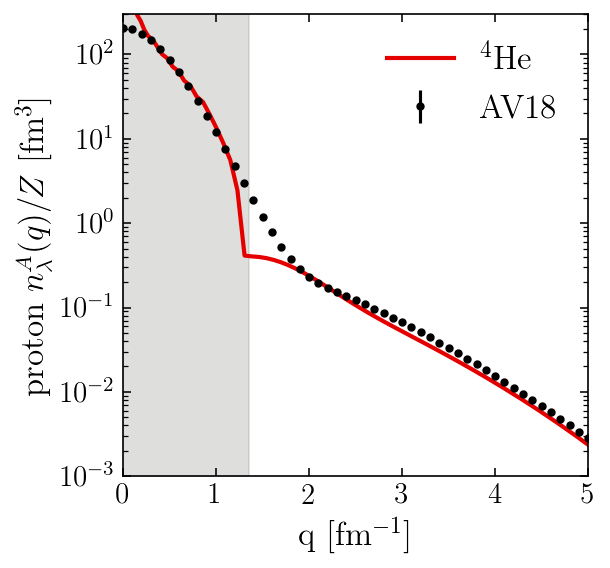

In [6]:
# Compare to AV18 QMC He4 momentum distribution
# (copied from snmd_tails_with_AV18 in src_physics_fig.ipynb)

# Figure size
row_number = 1
col_number = 1
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = 'q [fm' + r'$^{-1}$' + ']'
x_label_size = 16
y_label = 'proton ' + r'$n_{\lambda}^A(q)/Z$' + ' [fm' + r'$^3$' + ']'
y_label_size = 16

# Axes limits
xlim = (0, 5)
if nucleus == 'He4':
    ylim = (1e-3, 3e2)
elif nucleus == 'He8':
    ylim = (1e-3, 3e2)
elif nucleus == 'Be9':
    ylim = (1e-3, 2e2)
else:
    ylim = (1e-3, 1e2)
    
# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size)

# Use interpolated function for proton distribution
snmd = single_nucleon_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot, interp=True)

nucleon = 'proton'
# Ignore 1, \delta U, and \delta U^2 isolated contributions (take total only)
n_p_func, _, _, _ = snmd.n_lambda_interp(nucleus, nucleon, Z, N)

# Evaluate at all q values
n_p_array = n_p_func(q_array)

# Legend label
curve_label = ff.nuclei_label_conversion(nucleus) # Labels the nucleus
    
# Set y-axis to log scale
ax.set_yscale('log')
    
# Add curve to figure dividing by Z
ax.plot(q_array, n_p_array/Z, color='xkcd:red', label=curve_label, linewidth=curve_width)
        
# Add AV18 data with error bars
av18_data = np.loadtxt('data/qmc/AV18_%s_snmd.txt' % nucleus)
if nucleus == 'Be9':
    q_array_p_av18 = av18_data[:, 0] # fm^-1
    n_p_array_av18 = av18_data[:, 3]
    error_bars_array_av18 = av18_data[:, 4]
else:
    q_array_p_av18 = av18_data[:, 0] # fm^-1
    n_p_array_av18 = av18_data[:, 1]
    error_bars_array_av18 = av18_data[:, 2]
            
# AV18 data with error bars
ax.errorbar(q_array_p_av18, n_p_array_av18/Z, yerr=error_bars_array_av18/Z, color='xkcd:black', label='AV18',
            linestyle='', marker='.')
    
# Shade gray from 0 to \lambda value on plot
ax.fill_betweenx(ylim, 0.0, lamb, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.3)

# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)
        
# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)

# Add legend
legend_size = 16
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file_name 
file_name = 'proton_snmd_kvnn_%d_%s_lamb_%s_channels_%s' % ( kvnn, nucleus, ff.convert_number_to_string(lamb),
                                                             channels_label)
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [7]:
# print(q_array[60], n_p_array[60]/Z)
# print(q_array_p_av18[30], n_p_array_av18[30]/Z)
# print(np.sum(q_weights*q_array**2*n_p_array/Z)*4*np.pi/(2*np.pi)**3)
# print(np.sum(0.1*q_array_p_av18**2*n_p_array_av18/Z)*4*np.pi/(2*np.pi)**3)

__Pair momentum distributions__

In [8]:
# Initialize pair momentum distributions class
pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot, interp=True)

# Get densities
if nucleus == 'He8' or nucleus == 'Be9':
    R_array, rho_p_array = load_density(nucleus, 'proton', Z, N, 'AV18')
    R_array, rho_n_array = load_density(nucleus, 'neutron', Z, N, 'AV18')
else:
    R_array, rho_p_array = load_density(nucleus, 'proton', Z, N, 'SLY4')
    R_array, rho_n_array = load_density(nucleus, 'neutron', Z, N, 'SLY4')
dR = R_array[2] -  R_array[1]

Ntot = 40
# Evaluate kF values at each point in R_array to set max value of Q
kFp_array = (3*np.pi**2 * rho_p_array)**(1/3)
kFn_array = (3*np.pi**2 * rho_n_array)**(1/3)
Q_max = max(kFp_array) + max(kFn_array)
Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, Ntot)

# Get interpolating functions
n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus, 'pn', Z, N)
n_pp_func, _, _, _ = pmd.n_lambda_interp(nucleus, 'pp', Z, N)

# Calculate 2-D array of (q, Q) points
q_mesh, Q_mesh = np.meshgrid(q_array, Q_array, indexing='ij')
n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh)
n_pp_array_2d = n_pp_func.ev(q_mesh, Q_mesh)

# Integrate out Q dependence
factor = 4*np.pi/(2*np.pi)**3
_, Q_grid = np.meshgrid(q_array, Q_array**2*Q_weights, indexing='ij')
    
n_pn_array = factor * np.sum(Q_grid * n_pn_array_2d, axis=-1)
n_pp_array = factor * np.sum(Q_grid * n_pp_array_2d, axis=-1)

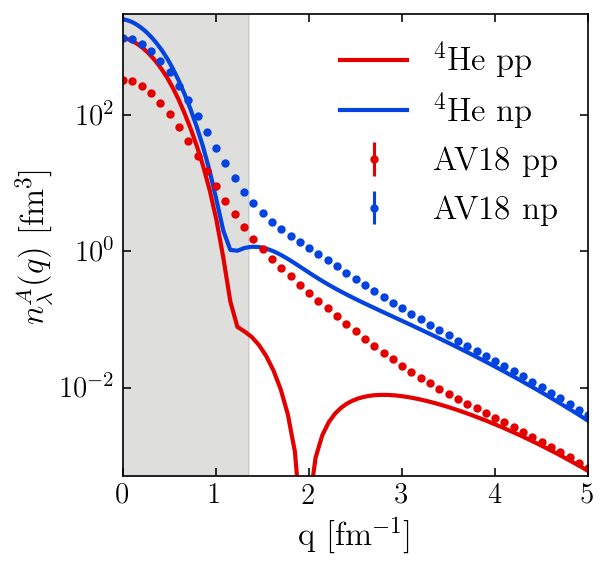

In [9]:
# Compare to AV18 QMC He4 pair momentum distribution

# Figure size
row_number = 1
col_number = 1
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = 'q [fm' + r'$^{-1}$' + ']'
x_label_size = 16
y_label = r'$n_{\lambda}^A(q)$' + ' [fm' + r'$^3$' + ']'
y_label_size = 16

# Axes limits
xlim = (0.0, 5)
if nucleus == 'He4':
    ylim = (5e-4, 3e3)
elif nucleus == 'He8':
    ylim = (5e-4, 1e4)
else:
    ylim = (5e-4, 2e4)
    
# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size)

# Set y-axis to log scale
ax.set_yscale('log')
    
# Add curve to figure
ax.plot(q_array, n_pp_array, color='xkcd:red', label=ff.nuclei_label_conversion(nucleus) + ' pp',
        linewidth=curve_width)
ax.plot(q_array, n_pn_array, color='xkcd:blue', label=ff.nuclei_label_conversion(nucleus) + ' np',
        linewidth=curve_width)
        
# Add AV18 data with error bars
av18_data = np.loadtxt('data/qmc/AV18_%s_pmd_q.txt' % nucleus)
q_array_NN_av18 = av18_data[:, 0] # fm^-1
if nucleus == 'He8' or nucleus == 'Be9':
    n_pn_array_av18 = av18_data[:, 3]
    pn_error_bars_array_av18 = av18_data[:, 4]
    n_pp_array_av18 = av18_data[:, 5]
    pp_error_bars_array_av18 = av18_data[:, 6]
else:
    n_pn_array_av18 = av18_data[:, 1]
    pn_error_bars_array_av18 = av18_data[:, 2]
    n_pp_array_av18 = av18_data[:, 3]
    pp_error_bars_array_av18 = av18_data[:, 4]
            
# AV18 data with error bars
ax.errorbar(q_array_NN_av18, n_pp_array_av18, yerr=pp_error_bars_array_av18, color='xkcd:red', label='AV18 pp',
            linestyle='', marker='.')
ax.errorbar(q_array_NN_av18, n_pn_array_av18, yerr=pn_error_bars_array_av18, color='xkcd:blue', label='AV18 np',
            linestyle='', marker='.')

# Shade gray from 0 to \lambda value on plot
ax.fill_betweenx(ylim, 0.0, lamb, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.3)

# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)
        
# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)

# Add legend
legend_size = 16
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file_name 
file_name = 'pmd_kvnn_%d_%s_lamb_%s_channels_%s' % ( kvnn, nucleus, ff.convert_number_to_string(lamb),
                                                     channels_label)
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [10]:
# print(factor * np.sum(q_array**2*q_weights*n_pn_array))
# print(factor * np.sum(q_array**2*q_weights*n_pp_array))
# print(factor * np.sum(q_array_NN_av18**2*0.1*n_pn_array_av18))
# print(factor * np.sum(q_array_NN_av18**2*0.1*n_pp_array_av18))   

In [11]:
# print(q_array[60], n_pp_array[60])
# print(q_array_NN_av18[30], n_pp_array_av18[30])

In [12]:
# print(q_array[60], n_pn_array[60])
# print(q_array_NN_av18[30], n_pn_array_av18[30])

__Check asymptotic relation between single-nucleon and pair momentum distributions__

In [13]:
# header = '{:^18s}{:^18s}{:^18s}{:^18s}{:^18s}'.format('q', 'p', '2pp+pn', 'pp', 'pn')
# print(header + '\n')

# # Just loop for now
# for iq, n_snmd, n_pp, n_pn in zip(q_array, n_p_array, n_pp_array, n_pn_array):
    
#     # 2*F_pp(q) + F_pn(q) where F_pn means np+pn
#     n_pmd = 2*n_pp + n_pn
    
#     # Write to data file following the format from the header
#     line = '{:^18.6f}{:^18.6e}{:^18.6e}{:^18.6e}{:^18.6e}'.format(iq, n_snmd, n_pmd, n_pp, n_pn)
#     print(line)

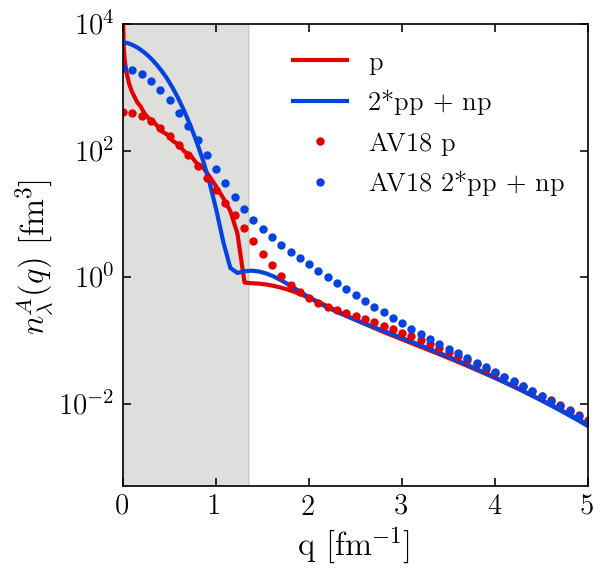

In [14]:
# Put pair and single-nucleon momentum distributions on same plot

# Figure size
row_number = 1
col_number = 1
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = 'q [fm' + r'$^{-1}$' + ']'
x_label_size = 16
y_label = r'$n_{\lambda}^A(q)$' + ' [fm' + r'$^3$' + ']'
y_label_size = 16

# Axes limits
xlim = (0.0, 5)
if nucleus == 'He4':
    ylim = (5e-4, 1e4)
elif nucleus == 'He8':
    ylim = (1e-3, 2e4)
elif nucleus == 'Be9':
    ylim = (1e-3, 3e4)
else:
    ylim = (1e-3, 4e4)
    
# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size)

# Set y-axis to log scale
ax.set_yscale('log')
    
# Add curves to figure
ax.plot(q_array, n_p_array, color='xkcd:red', label='p', linewidth=curve_width)
ax.plot(q_array, 2*n_pp_array+n_pn_array, color='xkcd:blue', label='2*pp + np', linewidth=curve_width)
        
# AV18 data with error bars
ax.plot(q_array_p_av18, n_p_array_av18, color='xkcd:red', label='AV18 p', linestyle='', marker='.')
ax.plot(q_array_NN_av18, 2*n_pp_array_av18+n_pn_array_av18, color='xkcd:blue', label='AV18 2*pp + np',
        linestyle='', marker='.')

# Shade gray from 0 to \lambda value on plot
ax.fill_betweenx(ylim, 0.0, lamb, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.3)

# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)
        
# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)

# Add legend
legend_size = 13
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file_name 
file_name = 'snmd_pmd_asy_kvnn_%d_%s_lamb_%s_channels_%s' % ( kvnn, nucleus, ff.convert_number_to_string(lamb),
                                                              channels_label )
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

__Compare $n_{\lambda}^{\tau \tau'}(q, 0)$ for $^{12}$C__

In [20]:
# Initialize pair momentum distributions class
pmd_Q0 = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot, interp=False)

# Get densities
R_array, rho_p_array = load_density('C12', 'proton', 6, 6, 'SLY4')
R_array, rho_n_array = load_density('C12', 'neutron', 6, 6, 'SLY4')
dR = R_array[2] -  R_array[1]

t0 = time.time()
n_pn_array = 2*pmd_Q0.n_Q0(q_array, R_array, dR, rho_p_array, rho_n_array)
n_pp_array = pmd_Q0.n_Q0(q_array, R_array, dR, rho_p_array)
t1 = time.time()
print('%.5f minutes elapsed.' % ( (t1-t0)/60 ) )

0.02489 minutes elapsed.


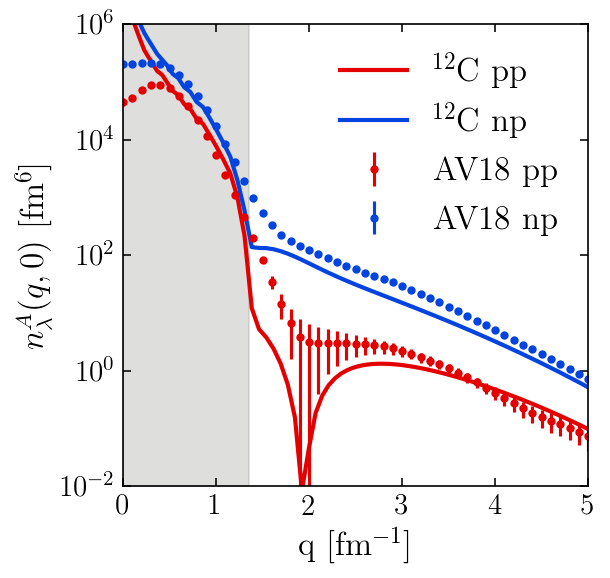

In [21]:
# Compare to AV18 QMC C12 pair momentum distribution

# Figure size
row_number = 1
col_number = 1
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = 'q [fm' + r'$^{-1}$' + ']'
x_label_size = 16
y_label = r'$n_{\lambda}^A(q, 0)$' + ' [fm' + r'$^6$' + ']'
y_label_size = 16

# Axes limits
xlim = (0.0, 5)
ylim = (1e-2, 1e6)
    
# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size)

# Set y-axis to log scale
ax.set_yscale('log')
    
# Add curve to figure
ax.plot(q_array, n_pp_array, color='xkcd:red', label=ff.nuclei_label_conversion('C12') + ' pp',
        linewidth=curve_width)
ax.plot(q_array, n_pn_array, color='xkcd:blue', label=ff.nuclei_label_conversion('C12') + ' np',
        linewidth=curve_width)
        
# Add AV18 data with error bars
av18_data = np.loadtxt('data/qmc/AV18_%s_pmd_q_Q0.txt' % 'C12')
q_array_NN_av18 = av18_data[:, 0] # fm^-1
n_pn_array_av18 = av18_data[:, 1]
pn_error_bars_array_av18 = av18_data[:, 2]
n_pp_array_av18 = av18_data[:, 3]
pp_error_bars_array_av18 = av18_data[:, 4]
            
# AV18 data with error bars
ax.errorbar(q_array_NN_av18, n_pp_array_av18, yerr=pp_error_bars_array_av18, color='xkcd:red', label='AV18 pp',
            linestyle='', marker='.')
ax.errorbar(q_array_NN_av18, n_pn_array_av18, yerr=pn_error_bars_array_av18, color='xkcd:blue', label='AV18 np',
            linestyle='', marker='.')

# Shade gray from 0 to \lambda value on plot
ax.fill_betweenx(ylim, 0.0, lamb, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.3)

# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)
        
# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)

# Add legend
legend_size = 16
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file_name 
file_name = 'pmd_Q0_kvnn_%d_%s_lamb_%s_channels_%s' % ( kvnn, 'C12', ff.convert_number_to_string(lamb),
                                                        channels_label )
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

__Compare $n_{\lambda}^{\tau \tau'}(q, Q)$ for $^{4}$He fixing $Q$__

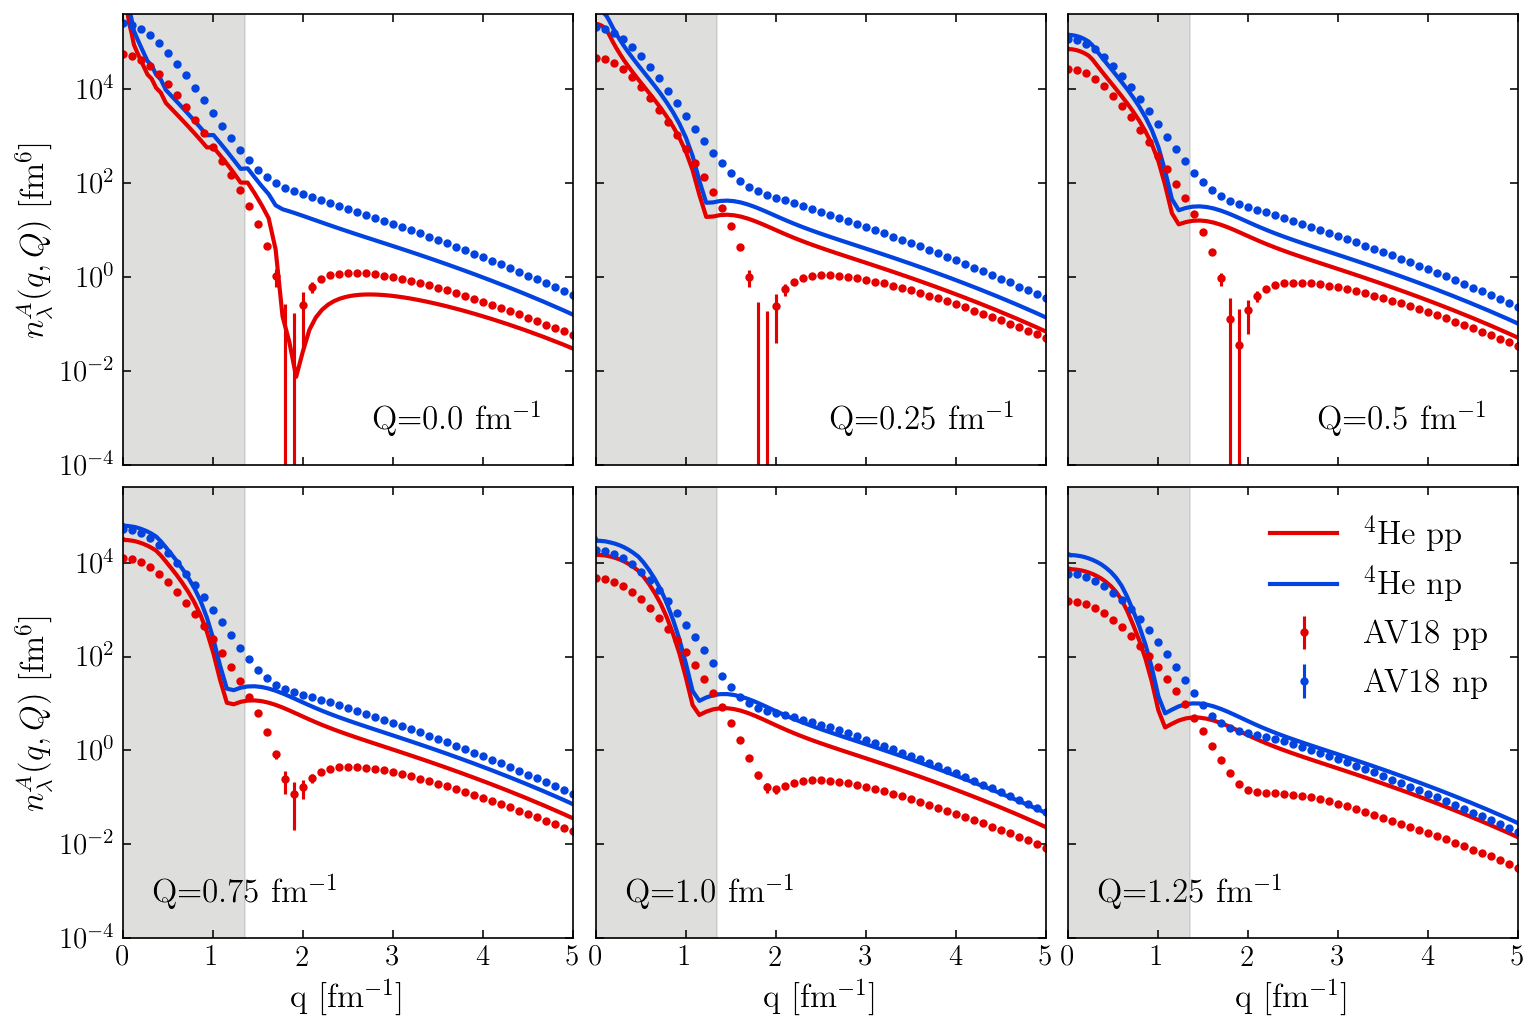

In [19]:
# Initialize pair momentum distributions class
pmd_Q_fixed = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot, interp=False)

# Get densities
R_array, rho_p_array = load_density('He4', 'proton', 2, 2, 'AV18')
rho_n_array = rho_p_array
dR = R_array[2] -  R_array[1]

# Get interpolating functions
n_pn_func, _, _, _ = pmd_Q_fixed.n_lambda_interp('He4', 'pn', 2, 2)
n_pp_func, _, _, _ = pmd_Q_fixed.n_lambda_interp('He4', 'pp', 2, 2)

# Initialize multiplot figure

# Figure size
row_number = 2
col_number = 3
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = 'q [fm' + r'$^{-1}$' + ']'
x_label_size = 16
y_label = r'$n_{\lambda}^A(q,Q)$' + ' [fm' + r'$^6$' + ']'
y_label_size = 16

# Axes limits
xlim = (0, 5)
ylim = (1e-4, 4e5)

# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)

# Calculate 1-D array with respect to q fixing Q
Q_points = np.arange(0.0, 1.5, 0.25)
for iQ, Q_fixed in enumerate(Q_points):
    
    # Set subplot coordinates
    if iQ < 3:
        i, j = 0, iQ
    else:
        i, j = 1, iQ % col_number
    
    if Q_fixed == 0.0:
        n_pn_array = 2*pmd_Q_fixed.n_Q0(q_array, R_array, dR, rho_p_array, rho_n_array)
        n_pp_array = pmd_Q_fixed.n_Q0(q_array, R_array, dR, rho_p_array)
        
    else:
        n_pn_array = 2*n_pn_func.ev(q_array, Q_fixed)
        n_pp_array = n_pn_func.ev(q_array, Q_fixed)

    # Set y-axis to log scale
    axs[i, j].set_yscale('log')
    
    # Add curve to figure
    axs[i, j].plot(q_array, n_pp_array, color='xkcd:red', label=ff.nuclei_label_conversion('He4') + ' pp',
                   linewidth=curve_width)
    axs[i, j].plot(q_array, n_pn_array, color='xkcd:blue', label=ff.nuclei_label_conversion('He4') + ' np',
                   linewidth=curve_width)
        
    # Add AV18 data with error bars
    if Q_fixed == 0.0:
        Q_str = '0'
    elif Q_fixed == 0.25:
        Q_str = '0p25'
    elif Q_fixed == 0.5:
        Q_str = '0p5'
    elif Q_fixed == 0.75:
        Q_str = '0p75'
    elif Q_fixed == 1.0:
        Q_str = '1'
    elif Q_fixed == 1.25:
        Q_str = '1p25'
#     elif Q_fixed == 1.5:
#         Q_str = '1p5'
#     elif Q_fixed == 2.0:
#         Q_str = '2'
#     elif Q_fixed == 2.5:
#         Q_str = '2p5'
    file_name = 'AV18_%s_pmd_q_Q%s.txt' % ('He4', Q_str)
    av18_data = np.loadtxt('data/qmc/' + file_name)
    q_array_NN_av18 = av18_data[:, 0] # fm^-1
    n_pn_array_av18 = av18_data[:, 1]
    pn_error_bars_array_av18 = av18_data[:, 2]
    n_pp_array_av18 = av18_data[:, 3]
    pp_error_bars_array_av18 = av18_data[:, 4]
            
    # AV18 data with error bars
    axs[i, j].errorbar(q_array_NN_av18, n_pp_array_av18, yerr=pp_error_bars_array_av18, color='xkcd:red',
                       label='AV18 pp', linestyle='', marker='.')
    axs[i, j].errorbar(q_array_NN_av18, n_pn_array_av18, yerr=pn_error_bars_array_av18, color='xkcd:blue',
                       label='AV18 np', linestyle='', marker='.')

    # Shade gray from 0 to \lambda value on plot
    axs[i, j].fill_betweenx(ylim, 0.0, lamb, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.3)

    # Specify axes limits
    axs[i, j].set_xlim(xlim)
    axs[i, j].set_ylim(ylim)
        
    # Set axes labels
    if i == 1:
        axs[i, j].set_xlabel(x_label, fontsize=x_label_size)
    if j == 0:
        axs[i, j].set_ylabel(y_label, fontsize=y_label_size)

    # Add legend
    if i == 1 and j == 2:
        legend_size = 16
        legend_location = 'upper right'
        axs[i, j].legend(loc=legend_location, frameon=False, fontsize=legend_size)
    
    # Q label
    Q_label = 'Q=%s' % ff.convert_number_to_string(Q_fixed) + ' fm' + r'$^{-1}$'
    if i == 0:
        Q_label_location = 'lower right'
    else:
        Q_label_location = 'lower left'
    Q_label_size = 16
    anchored_text = AnchoredText(Q_label, loc=Q_label_location, prop=dict(size=Q_label_size), frameon=False)
    axs[i, j].add_artist(anchored_text)
    
    
# Amount of white space in-between sub-plots
f.subplots_adjust(hspace=0.05, wspace=0.05)

# Set file_name 
file_name = 'pmd_Q_fixed_kvnn_%d_%s_lamb_%s_channels_%s' % ( kvnn, 'He4', ff.convert_number_to_string(lamb),
                                                             channels_label)
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

__Deuteron momentum distribution__

In [ ]:
# # Compare deuteron LDA to AV18 deuteron

# channel = '3S1'
# factor_array = q_array**2 * q_weights
    
# # Load hamiltonian
# H_matrix = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    
# # Load exact wave function [unitless]
# psi_exact_unitless = ob.wave_function(H_matrix)
# psi_squared_exact = ( psi_exact_unitless[:ntot]**2 + psi_exact_unitless[ntot:]**2 ) / factor_array
        
# # Calculate using LDA
# dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot, interp=True)

# # Ignore 1, \delta U, and \delta U^2 isolated contributions (take total only)
# n_d_func, _, _, _ = dmd.n_lambda_interp()

# # Evaluate at all q values
# n_d_array = n_d_func(q_array)
    
# # Normalization of wave function
# norm = np.sum(factor_array * psi_squared_exact)
# print('Normalization of exact: \dq q^2 n_d(q) = %.5f' % norm)
    
# # Normalization of LDA deuteron momentum distribution
# lda_factor = 4*np.pi * 1/(2*np.pi)**3
# norm_lda = lda_factor * np.sum(factor_array * n_d_array)
# print('Normalization of LDA: 4\pi/(2\pi)^3 \dq q^2 <n_d^N(q)> = %.5f' % norm_lda) 
    
# # Plot pair momentum distributions
# plt.semilogy(q_array, psi_squared_exact, label='AV18 wave function')
# plt.semilogy(q_array, n_d_array * lda_factor, label='LDA')
# plt.xlim( (0.0, 5.0) )
# plt.ylim( (1e-5, 5e2) )
# plt.xlabel(r'$q$' + ' [fm' + r'$^{-1}$' + ']')
# plt.ylabel(r'$n_d(q)$' + ' [fm' + r'$^3$' + ']')
# plt.legend(loc=0)